In [30]:
import pickle
import yaml
import torch

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "mathptmx",
    'font.size': 20
})

In [31]:
configs = yaml.safe_load(open("config/config.yml")) 
config = configs['continuous']['sigma']['sigma_01']

In [32]:
with open(f'../results/{config["name"]}.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [33]:
t = data['t']
x = data['x']
y_data = data['y_data']
true = data['true']
x_preds = data['x_preds']
domain = [-1, 1]


In [62]:
def calculate_mean_and_quantile(x_preds):
    x_mean = torch.mean(x_preds, axis=0)
    lower_quantile = torch.quantile(x_preds, 0.05, axis=0)
    upper_quantile = torch.quantile(x_preds, 0.95, axis=0)

    return x_mean, lower_quantile, upper_quantile


def plot_results(config, t, x, true, y_data, x_preds):
    x_mean, lower_quantile, upper_quantile = calculate_mean_and_quantile(x_preds)

    plt.figure()
    plt.plot(x, true, label='true')
    plt.plot(t, y_data, label='data')

    line, = plt.plot(t, x_mean, label='inverse solution')
    # Plot the quantile range as a shaded area
    plt.fill_between(x, lower_quantile, upper_quantile, color=line.get_color(), alpha=0.5, label='90% quantile range')
    #plt.plot(t, A@x_solution.numpy(), label='A @ solution')
    plt.axis([domain[0], domain[1], -0.1, 1.5])
    plt.xlabel('t')
    plt.ylabel('x')

    plt.savefig(f"plots/{config['plot_parameters']['solution_plot']}")


def plot_problem(problem_type: str,
                 config_name: str):

    with open(f'../results/{problem_type}_{config_name}.pickle', 'rb') as handle:
        data = pickle.load(handle)

    plt.figure()
    plt.plot(data['t'], data['true'],linewidth=0.7)
    plt.plot(data['x'], data['y_data'],linewidth=0.7)

    plt.axis([domain[0], domain[1], -0.5, 1.5])
    plt.savefig(f"../plots/{config_name}_problem.png")


def plot_initials():

    with open(f'../results/continuous_initial.pickle', 'rb') as handle:
        data_continuous = pickle.load(handle)
    with open(f'../results/discrete_initial.pickle', 'rb') as handle:
        data_discrete = pickle.load(handle)

    fig, axs = plt.subplots(1, 2)
    axs[0].plot(data_continuous['t'], data_continuous['true'])
    axs[0].plot(data_continuous['x'], data_continuous['y_data'])
    axs[0].axis([domain[0], domain[1], -0.5, 1.0])

    axs[1].plot(data_discrete['t'], data_discrete['true'])
    axs[1].plot(data_discrete['x'], data_discrete['y_data'])
    axs[1].axis([domain[0], domain[1], -1.0, 1.0])



    plt.savefig(f"../plots/initial_problems.png")

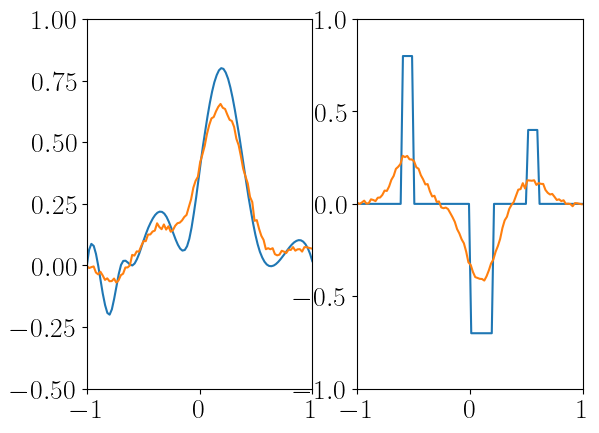

In [63]:
plot_initials()

In [46]:
def plot_sigma_subplots(configs, problem_type, experiment_type):

    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    ii, jj = 0, 0
    with open(f'../results/{problem_type}_initial.pickle', 'rb') as handle:
        data = pickle.load(handle)

    x_mean, lower_quantile, upper_quantile = calculate_mean_and_quantile(data['x_preds'])

    axs[ii, jj].plot(data['t'], data['true'])
    axs[ii, jj].plot(data['x'], data['y_data'])

    line, = axs[ii, jj].plot(data['t'], x_mean, label='inverse solution')
    axs[ii, jj].fill_between(data['t'], lower_quantile, upper_quantile, color=line.get_color(), alpha=0.2, label='90% quantile range')
    
    axs[ii, jj].set_title(f'$\sigma^2= {configs["initial"]["initial"][problem_type]["sigma_noise"]}^2$')
    jj = jj +1


    for idx, conf in enumerate(configs[problem_type][experiment_type]):
        with open(f'../results/{problem_type}_{conf}.pickle', 'rb') as handle:
            data = pickle.load(handle)
        
        x_mean, lower_quantile, upper_quantile = calculate_mean_and_quantile(data['x_preds'])

        axs[ii, jj].plot(data['t'], data['true'])
        axs[ii, jj].plot(data['x'], data['y_data'])

        line, = axs[ii, jj].plot(data['t'], x_mean, label='inverse solution')
        axs[ii, jj].fill_between(data['t'], lower_quantile, upper_quantile, color=line.get_color(), alpha=0.2, label='90% quantile range')
        
        axs[ii, jj].set_title(f'$\sigma^2= {configs[problem_type][experiment_type][conf]["sigma_noise"]}^2$')

        if problem_type == 'continuous':
            axs[ii, jj].axis([domain[0], domain[1], -0.5, 1.0])
        else:
            axs[ii, jj].axis([domain[0], domain[1], -1.0, 1.0])

        jj = jj +1
        if jj >1:
            ii = ii +1
            jj = 0
    plt.tight_layout()



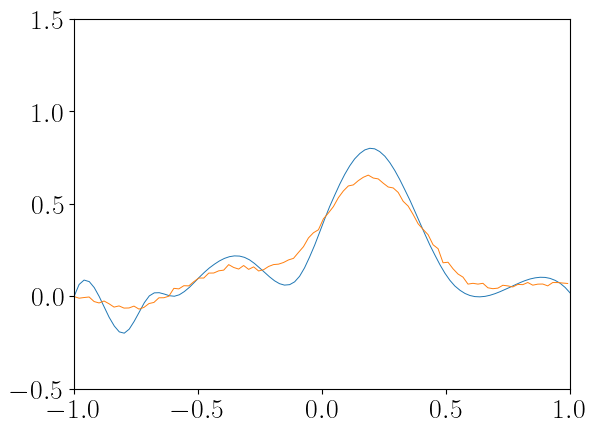

In [47]:
plot_problem('continuous', 'initial')

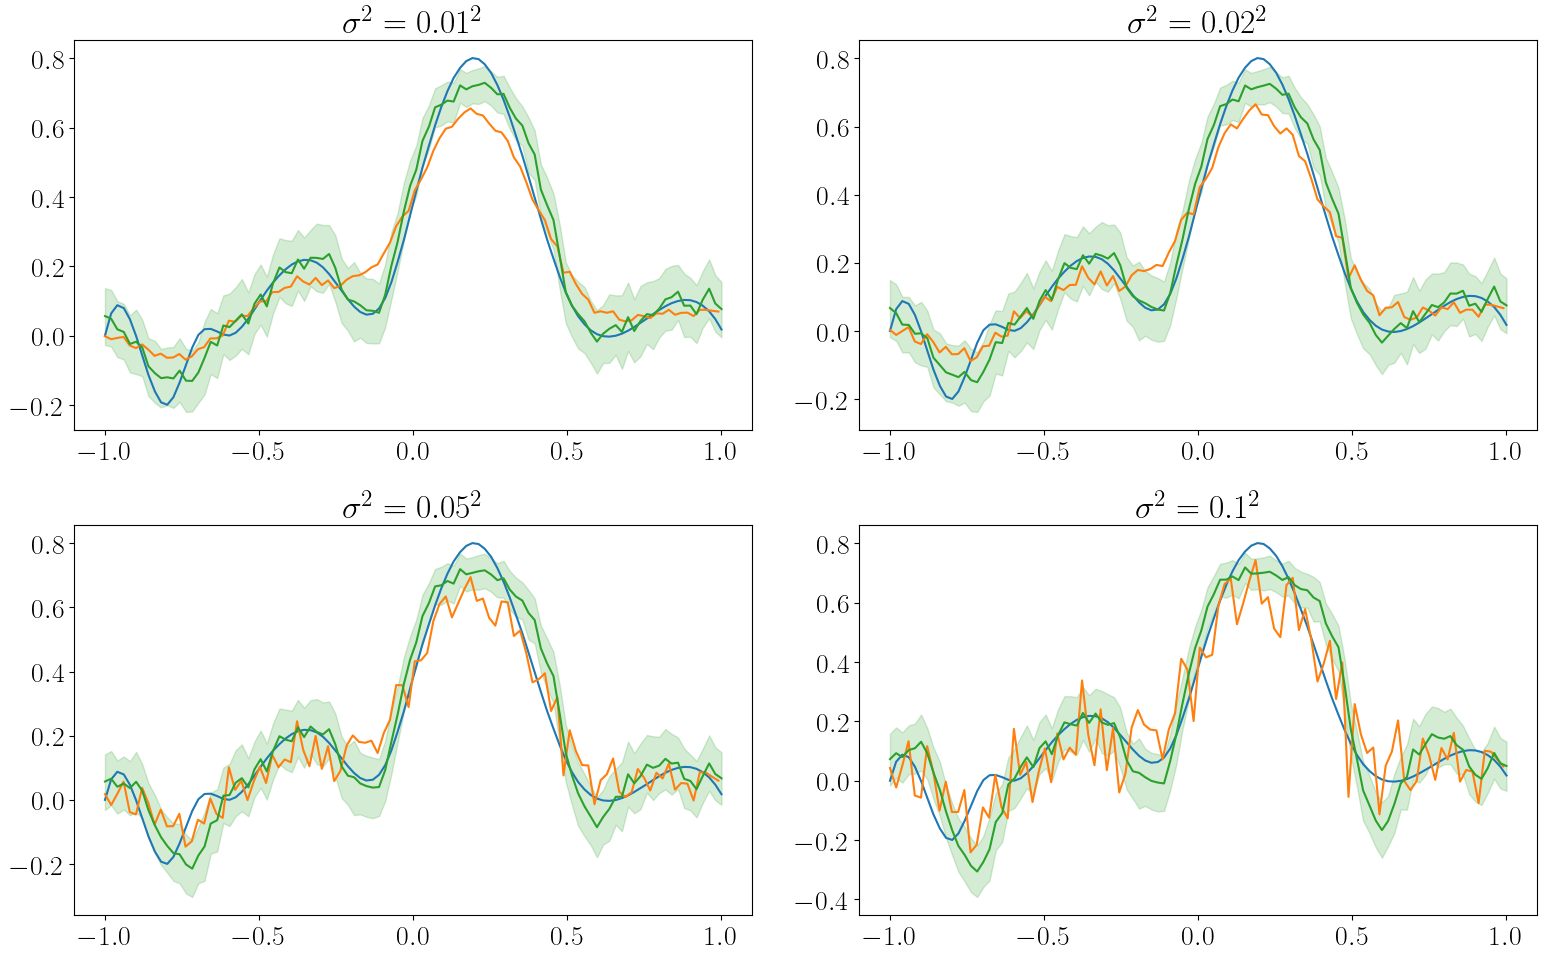

In [48]:
plot_sigma_subplots(configs, 'continuous','sigma')

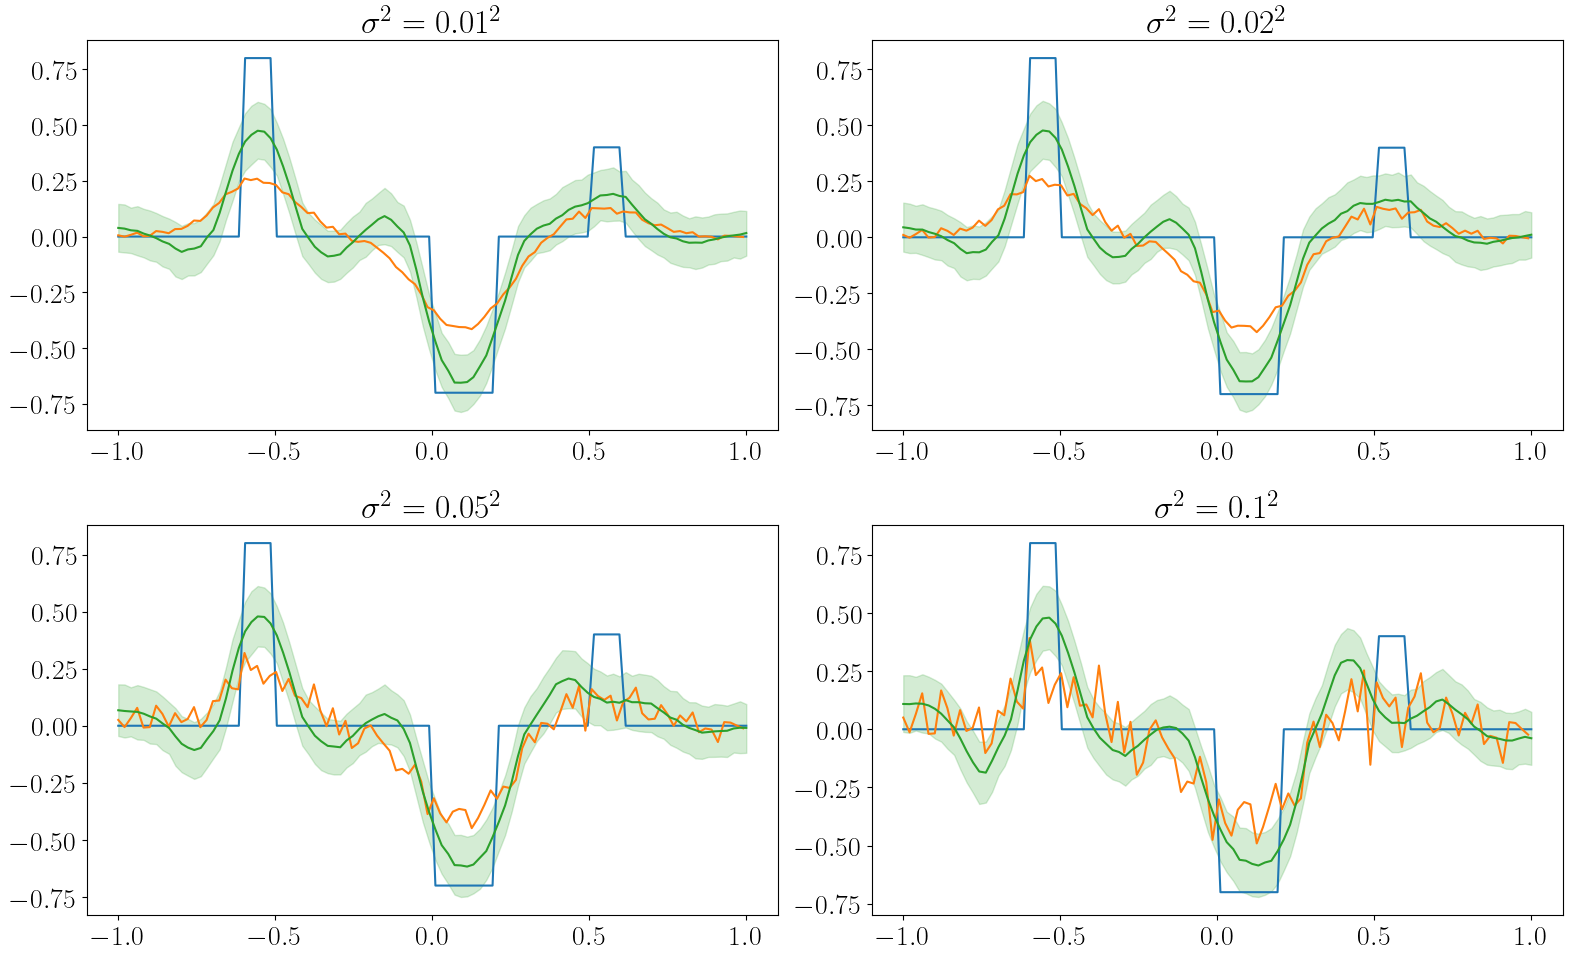

In [49]:
plot_sigma_subplots(configs, 'discrete','sigma')